In [59]:
import sys
import os
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import sqlalchemy as sq
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import tensorflow
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

sys.path.append("../Shared/")
from DataService import DataService

# fetch data from db

In [2]:
# function to update logs
def updateLog(fileName: str, message: str) -> None:
    try:
        if fileName is not None:
            with open(fileName, "a") as log:
                log.write(message + "\n")
    except Exception as e:
        print(message)

In [3]:
LOG_FILE = "/data/pull_moisture.log"

load_dotenv()
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

In [4]:
if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    updateLog(LOG_FILE, "Missing database credentials")
    raise ValueError("Environment variables are not set")
else:
    # connicting to database
    db = DataService(PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)
    conn = db.connect()

In [5]:
# pulling soil moisture data
query = sq.text("select * FROM public.agg_soil_moisture")
sm_df = pd.read_sql(query, conn)

In [6]:
sm_df.drop(columns=["index"], inplace=True)
sm_df.head()

,year,month,day,cr_num,district,soil_moisture_min,soil_moisture_max,soil_moisture_mean
0,1978,11,1,0,4612,0.165900,0.418710,0.237053
1,1978,11,1,5,4740,0.127140,0.207248,0.163722
2,1978,11,1,5,4741,0.153398,0.215304,0.170989
3,1978,11,1,7,4770,0.140772,0.186390,0.152211
4,1978,11,1,7,4771,0.116810,0.116810,0.116810


In [7]:
# pull ergot data
query = sq.text("select * FROM public.agg_ergot_samples")
ergot_df = pd.read_sql(query, conn)

In [8]:
ergot_df.shape

(158689, 18)

In [9]:
ergot_df.drop(columns=["sample_id", "incidence", "severity", "percnt_true", "sum_severity", "present_in_neighbor", "severity_in_neighbor"], inplace=True)

In [10]:
ergot_df = ergot_df.drop_duplicates()

In [11]:
ergot_df.sample(5)

,year,province,crop_district,district,has_ergot,present_prev1,present_prev2,present_prev3,severity_prev1,severity_prev2,severity_prev3
45461,1999,SK,41,4740,True,False,False,False,0.000000,0.000000,0.000000
78847,2005,SK,91,4790,True,True,True,False,0.033333,0.110048,0.000000
114822,2014,SK,31,4730,True,True,True,True,0.117647,0.043478,0.296296
115020,2014,SK,34,4733,False,False,False,True,0.000000,0.000000,0.187500
103951,2011,MB,11,4611,False,True,True,False,0.187500,1.000000,0.000000


In [12]:
# pull weather data
# in case reading csv
weather_df = pd.read_csv("data/aggregatedDly.csv")
weather_df.shape

(1064, 5478)

In [13]:
weather_df

,Unnamed: 0,year,district,01-01:max_temp,01-01:min_temp,01-01:mean_temp,01-01:min_total_rain,01-01:max_total_rain,01-01:mean_total_rain,01-01:min_total_snow,...,12-31:mean_total_rain,12-31:min_total_snow,12-31:max_total_snow,12-31:mean_total_snow,12-31:min_total_precip,12-31:max_total_precip,12-31:mean_total_precip,12-31:min_snow_on_grnd,12-31:max_snow_on_grnd,12-31:mean_snow_on_grnd
0,0,1995,4860,-8.0375,-20.200000,-14.137500,0.0,0.0,0.0,0.0,...,0.0,0.0,7.3,1.70,0.0,1.5,0.444444,0.0,36.0,16.333333
1,1,1995,4810,-7.4200,-17.000000,-12.220000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,19.0,6.600000
2,2,1995,4840,-8.3000,-19.425000,-13.875000,0.0,0.0,0.0,0.0,...,0.0,0.0,2.9,1.52,0.0,7.7,2.280000,0.0,24.0,8.800000
3,3,1995,4830,-5.7500,-20.258333,-13.033333,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,5.1,0.392308,0.0,28.0,5.615385
4,4,1995,4731,-7.3000,-19.650000,-13.500000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,1059,2022,4605,-28.3000,-33.000000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,27.0,27.0,27.000000
1060,1060,2022,4720,-24.8000,-36.900000,-30.850000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.1,0.050000,23.0,34.0,28.500000
1061,1061,2022,4611,-25.8000,-35.600000,-30.700000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.1,0.1,0.100000,14.0,14.0,14.000000
1062,1062,2022,4751,-22.9000,-33.600000,-28.300000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,6.0,6.0,6.000000


In [14]:
weather_df.drop(weather_df.columns[0], axis=1, inplace=True)

In [15]:
all_col = weather_df.columns.tolist()
uni_col = set()
for i in range (2,len(all_col)):
    # print(all_col[i].split(":")[1])
    uni_col.add(all_col[i].split(":")[1])

In [16]:
uni_col

{'max_snow_on_grnd',
 'max_temp',
 'max_total_precip',
 'max_total_rain',
 'max_total_snow',
 'mean_snow_on_grnd',
 'mean_temp',
 'mean_total_precip',
 'mean_total_rain',
 'mean_total_snow',
 'min_snow_on_grnd',
 'min_temp',
 'min_total_precip',
 'min_total_rain',
 'min_total_snow'}

In [17]:
for col_name in uni_col:
    # col_name = "max_temp"
    fil_col = weather_df.filter(like=col_name)
    weather_df[col_name] = fil_col.mean(axis=1)
    weather_df.drop(columns=fil_col.columns, inplace=True)

In [18]:
weather_df

,year,district,min_total_snow,mean_temp,min_temp,min_total_precip,max_total_snow,mean_total_rain,min_total_rain,max_snow_on_grnd,min_snow_on_grnd,mean_snow_on_grnd,mean_total_snow,max_temp,max_total_precip,max_total_rain,mean_total_precip
0,1995,4860,0.000000,0.451735,-5.342542,0.009589,1.438356,0.529384,0.00000,14.356164,0.000000,6.005903,0.303979,6.238637,4.561918,2.608767,1.189348
1,1995,4810,0.000000,4.239744,-2.249689,0.049589,0.416438,0.328105,0.00000,2.334247,0.000000,0.860822,0.116534,10.713096,2.528767,1.224110,0.871078
2,1995,4840,0.000000,1.628772,-4.348895,0.064110,0.565479,0.250507,0.00000,7.876712,0.175342,3.564932,0.155237,7.595941,2.203836,1.018630,0.790694
3,1995,4830,0.000000,3.060292,-3.321827,0.001918,1.108219,0.332711,0.00000,6.394521,0.000000,1.054999,0.135583,9.424064,5.339178,2.089863,1.299196
4,1995,4731,0.005479,2.796575,-2.909954,0.618356,0.016438,0.078265,0.00274,0.019178,0.002740,0.010959,0.010502,8.491324,1.211233,0.157260,0.908037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,2022,4605,0.000000,0.777808,-4.997808,1.151507,0.000000,0.000000,0.00000,14.356164,14.356164,14.356164,0.000000,6.552603,1.151507,0.000000,1.151507
1060,2022,4720,0.000000,2.653288,-3.850137,0.786027,0.000000,0.000000,0.00000,8.556164,4.482192,6.519178,0.000000,9.157397,1.409589,0.000000,1.097808
1061,2022,4611,0.000000,1.931507,-3.437808,2.099726,0.000000,0.000000,0.00000,5.945205,5.945205,5.945205,0.000000,7.302466,2.099726,0.000000,2.099726
1062,2022,4751,0.000000,1.386849,-3.926301,1.102466,0.000000,0.000000,0.00000,5.210959,5.210959,5.210959,0.000000,6.706301,1.102466,0.000000,1.102466


In [19]:
# joining tables
# df = pd.merge(sm_df, ergot_df, how="inner", on=["year", "district"])
df = pd.merge(sm_df, ergot_df)

In [20]:
df.shape

(63550, 17)

In [21]:
df = pd.merge(df, weather_df, on=["year", "district"])

In [22]:
df.shape

(61941, 32)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61941 entries, 0 to 61940
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                61941 non-null  int64  
 1   month               61941 non-null  int64  
 2   day                 61941 non-null  int64  
 3   cr_num              61941 non-null  int64  
 4   district            61941 non-null  int64  
 5   soil_moisture_min   61941 non-null  float64
 6   soil_moisture_max   61941 non-null  float64
 7   soil_moisture_mean  61941 non-null  float64
 8   province            61941 non-null  object 
 9   crop_district       61941 non-null  int64  
 10  has_ergot           61941 non-null  bool   
 11  present_prev1       61941 non-null  bool   
 12  present_prev2       61941 non-null  bool   
 13  present_prev3       61941 non-null  bool   
 14  severity_prev1      61941 non-null  float64
 15  severity_prev2      61941 non-null  float64
 16  seve

In [24]:
df

,year,month,day,cr_num,district,soil_moisture_min,soil_moisture_max,soil_moisture_mean,province,crop_district,...,mean_total_rain,min_total_rain,max_snow_on_grnd,min_snow_on_grnd,mean_snow_on_grnd,mean_total_snow,max_temp,max_total_precip,max_total_rain,mean_total_precip
0,1997,1,2,5,4741,0.154430,0.154430,0.154430,SK,42,...,0.573699,0.573699,0.000000,0.000000,0.000000,0.001096,10.781644,0.574795,0.573699,0.574795
1,1997,3,21,5,4741,0.160740,0.206815,0.183777,SK,42,...,0.573699,0.573699,0.000000,0.000000,0.000000,0.001096,10.781644,0.574795,0.573699,0.574795
2,1997,3,26,5,4741,0.169883,0.237919,0.212590,SK,42,...,0.573699,0.573699,0.000000,0.000000,0.000000,0.001096,10.781644,0.574795,0.573699,0.574795
3,1997,3,28,5,4741,0.239734,0.264594,0.251456,SK,42,...,0.573699,0.573699,0.000000,0.000000,0.000000,0.001096,10.781644,0.574795,0.573699,0.574795
4,1997,3,29,5,4741,0.252850,0.273013,0.261894,SK,42,...,0.573699,0.573699,0.000000,0.000000,0.000000,0.001096,10.781644,0.574795,0.573699,0.574795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61936,2017,10,26,2,4605,0.188417,0.317010,0.243329,MB,5,...,0.000000,0.000000,2.961644,2.961644,2.961644,0.000000,8.341370,0.849589,0.000000,0.849589
61937,2017,10,27,2,4605,0.166425,0.250064,0.198195,MB,5,...,0.000000,0.000000,2.961644,2.961644,2.961644,0.000000,8.341370,0.849589,0.000000,0.849589
61938,2017,10,28,2,4605,0.165371,0.254241,0.214900,MB,5,...,0.000000,0.000000,2.961644,2.961644,2.961644,0.000000,8.341370,0.849589,0.000000,0.849589
61939,2017,10,29,2,4605,0.183938,0.289150,0.242858,MB,5,...,0.000000,0.000000,2.961644,2.961644,2.961644,0.000000,8.341370,0.849589,0.000000,0.849589


In [25]:
# temp = pd.merge(ergot_df, weather_df)
# temp.columns

In [26]:
# g = sns.pairplot(temp.sample(1000))

/tmp/ipykernel_325141/3641604358.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


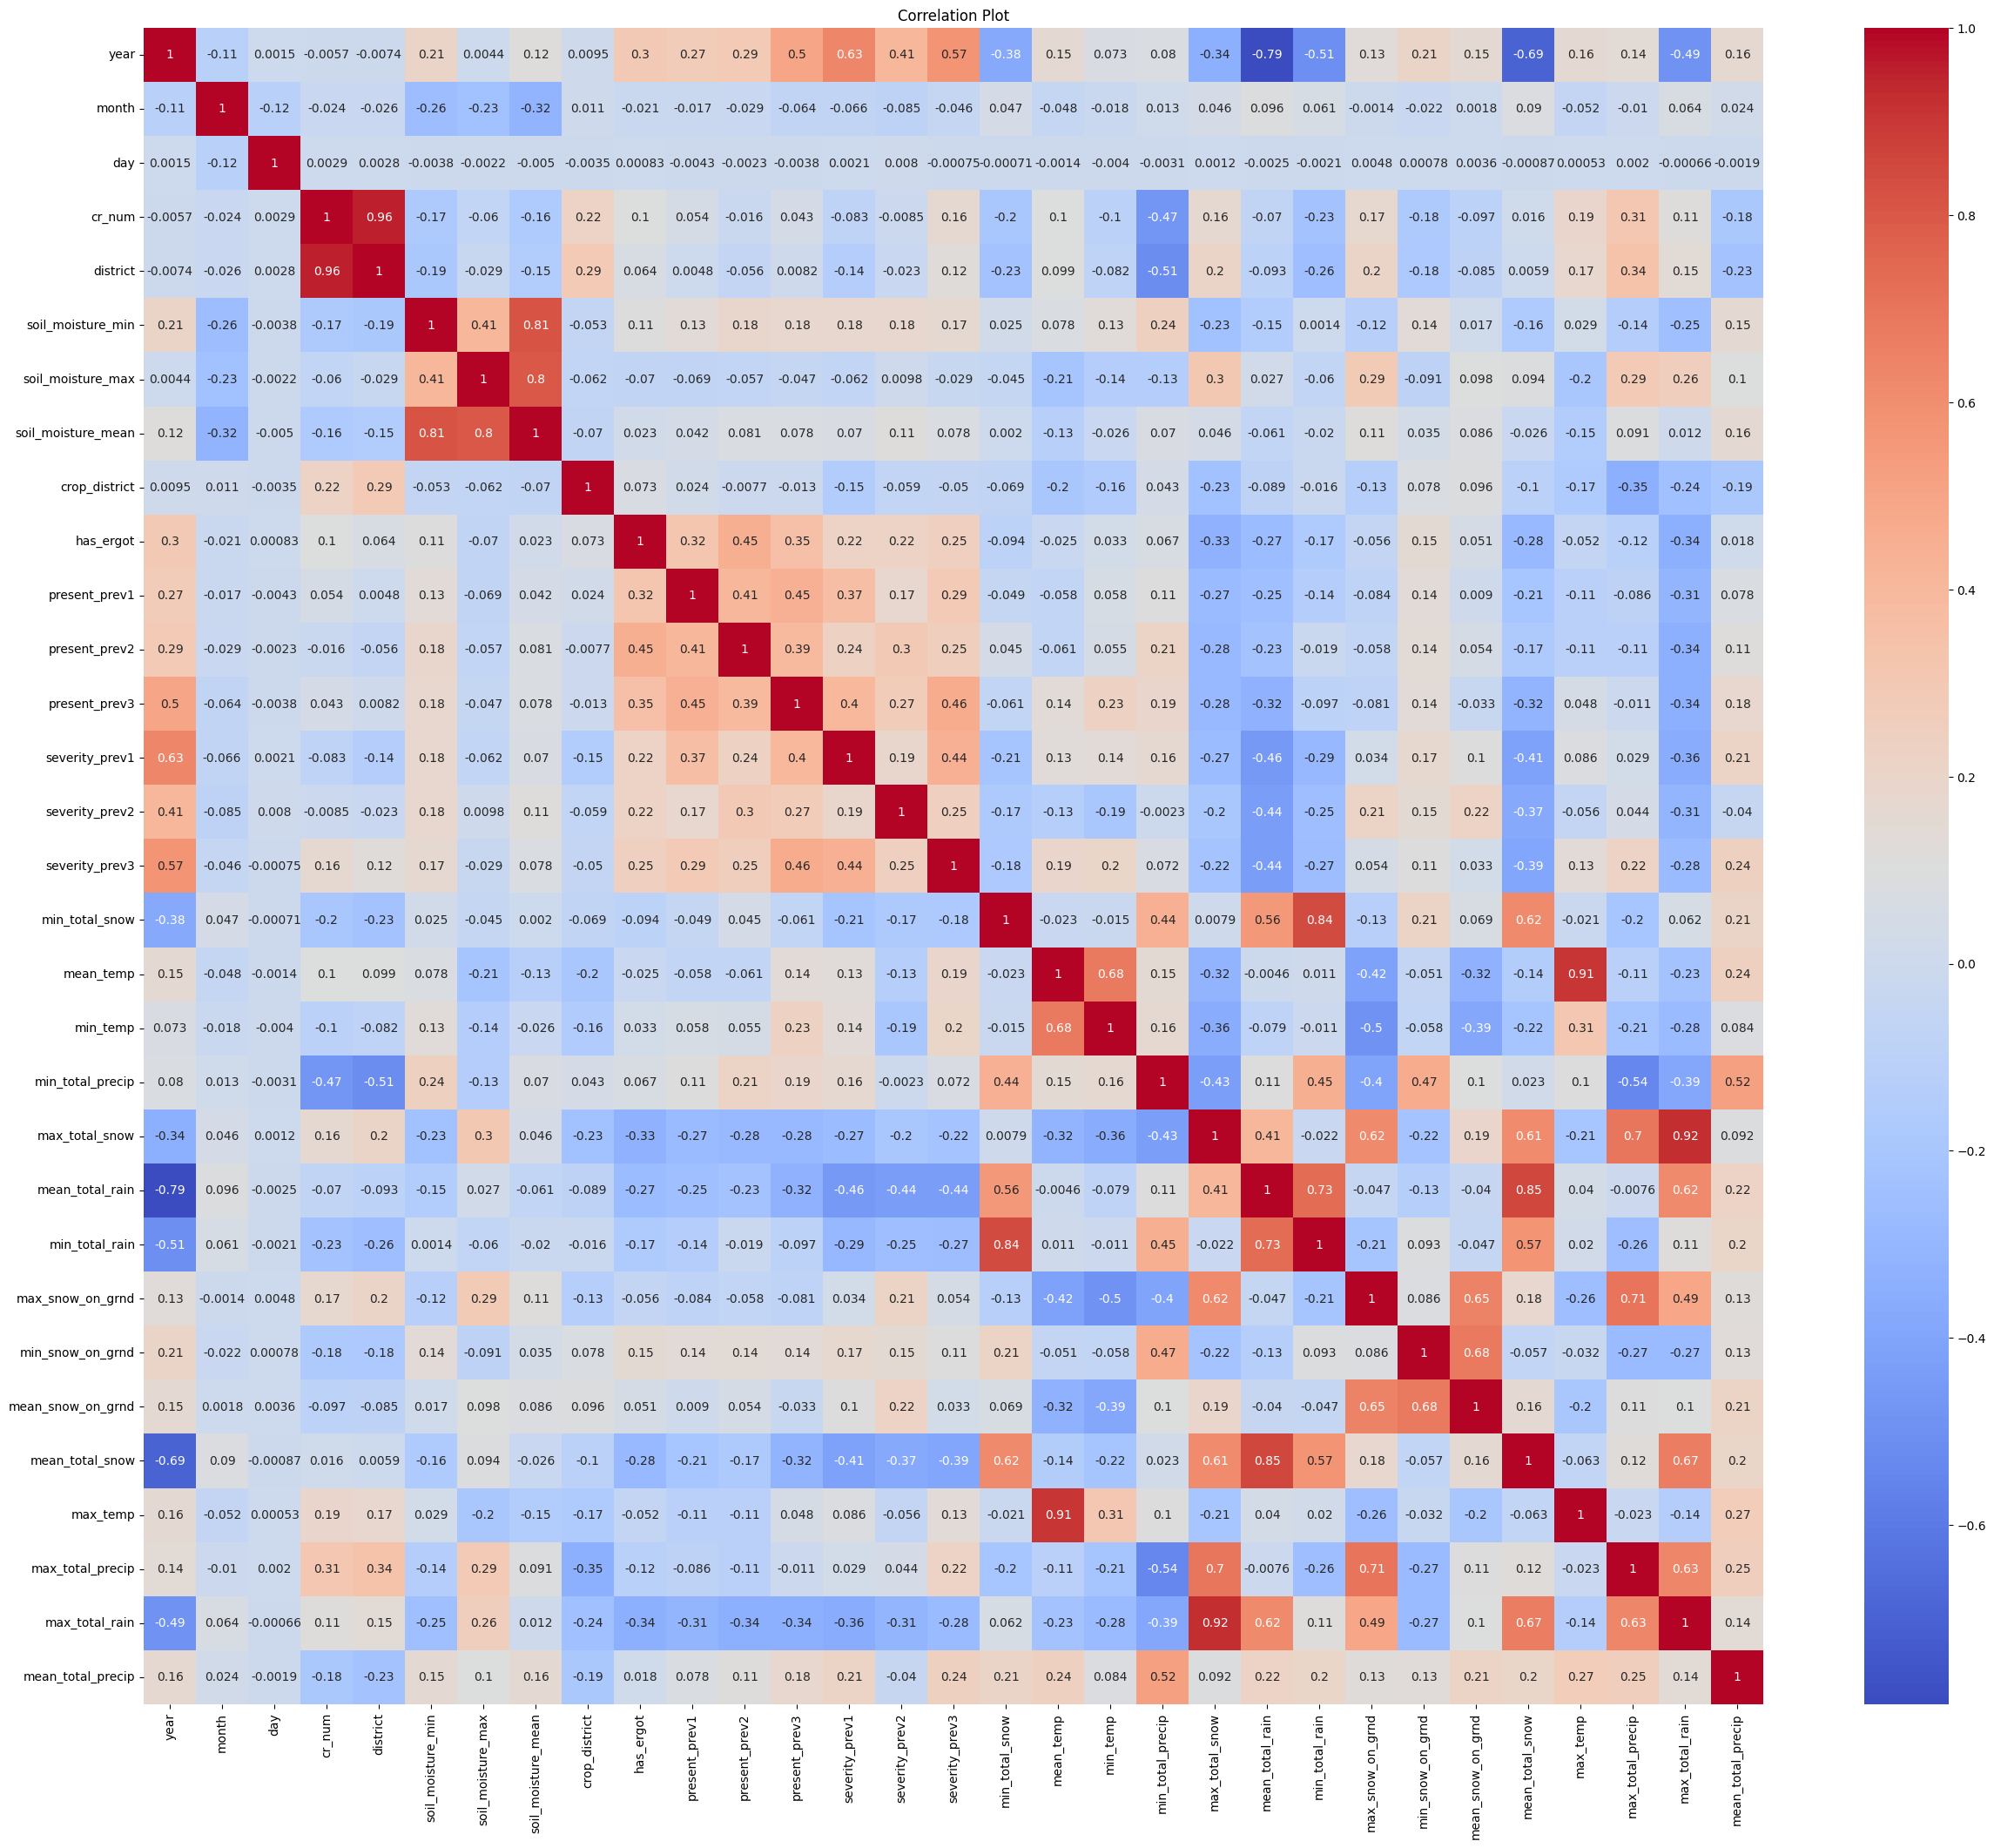

In [27]:
correlation_matrix = df.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

In [28]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [29]:
corr_features = correlation(df, 0.8)
len(set(corr_features))
corr_features

/tmp/ipykernel_325141/3726835926.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = dataset.corr()


{'district',
 'max_temp',
 'max_total_rain',
 'mean_total_snow',
 'min_total_rain',
 'soil_moisture_mean'}

In [30]:
df.drop(columns=corr_features, inplace=True)

In [31]:
# using one hot encoding to change catagorical variable to numarical
df = pd.get_dummies(df, columns=["province"], drop_first=True)

In [32]:
df

,year,month,day,cr_num,soil_moisture_min,soil_moisture_max,crop_district,has_ergot,present_prev1,present_prev2,...,min_total_precip,max_total_snow,mean_total_rain,max_snow_on_grnd,min_snow_on_grnd,mean_snow_on_grnd,max_total_precip,mean_total_precip,province_MB,province_SK
0,1997,1,2,5,0.154430,0.154430,42,False,False,False,...,0.574795,0.001096,0.573699,0.000000,0.000000,0.000000,0.574795,0.574795,0,1
1,1997,3,21,5,0.160740,0.206815,42,False,False,False,...,0.574795,0.001096,0.573699,0.000000,0.000000,0.000000,0.574795,0.574795,0,1
2,1997,3,26,5,0.169883,0.237919,42,False,False,False,...,0.574795,0.001096,0.573699,0.000000,0.000000,0.000000,0.574795,0.574795,0,1
3,1997,3,28,5,0.239734,0.264594,42,False,False,False,...,0.574795,0.001096,0.573699,0.000000,0.000000,0.000000,0.574795,0.574795,0,1
4,1997,3,29,5,0.252850,0.273013,42,False,False,False,...,0.574795,0.001096,0.573699,0.000000,0.000000,0.000000,0.574795,0.574795,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61936,2017,10,26,2,0.188417,0.317010,5,True,True,True,...,0.849589,0.000000,0.000000,2.961644,2.961644,2.961644,0.849589,0.849589,1,0
61937,2017,10,27,2,0.166425,0.250064,5,True,True,True,...,0.849589,0.000000,0.000000,2.961644,2.961644,2.961644,0.849589,0.849589,1,0
61938,2017,10,28,2,0.165371,0.254241,5,True,True,True,...,0.849589,0.000000,0.000000,2.961644,2.961644,2.961644,0.849589,0.849589,1,0
61939,2017,10,29,2,0.183938,0.289150,5,True,True,True,...,0.849589,0.000000,0.000000,2.961644,2.961644,2.961644,0.849589,0.849589,1,0


# split data

In [33]:
X = df.drop(columns=["has_ergot"])
y = df['has_ergot']
# y = df['has_ergot'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1, stratify=y)

In [34]:
# use StandardScaler when we don't know upper bounds
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
X_train_scaled.shape

(43358, 26)

In [36]:
tensorflow.config.set_visible_devices([], 'GPU')  # Hide GPU devices
tensorflow.config.set_visible_devices(tensorflow.config.list_physical_devices('CPU'), 'CPU')  # Show CPU devices


2023-07-03 14:44:47.593186: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:44:47.628766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 14:44:47.629051: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# creating model

In [46]:
model = Sequential()

model.add(Dense(15, activation="relu", input_dim = X.shape[1]))
# model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                405       
                                                                 
 dense_3 (Dense)             (None, 1)                 16        
                                                                 
Total params: 421
Trainable params: 421
Non-trainable params: 0
_________________________________________________________________


In [48]:
# compile model
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

In [49]:
history = model.fit(X_train_scaled, y_train, epochs=10, validation_split=0.2, shuffle=True, batch_size=32)

Epoch 1/10


1084/1084 [==============================] - 1s 1ms/step - loss: 0.2869 - accuracy: 0.8737 - val_loss: 0.2348 - val_accuracy: 0.9075
Epoch 2/10
1084/1084 [==============================] - 1s 902us/step - loss: 0.2283 - accuracy: 0.9056 - val_loss: 0.2152 - val_accuracy: 0.9125
Epoch 3/10
1084/1084 [==============================] - 1s 879us/step - loss: 0.2064 - accuracy: 0.9169 - val_loss: 0.1944 - val_accuracy: 0.9263
Epoch 4/10
1084/1084 [==============================] - 1s 882us/step - loss: 0.1864 - accuracy: 0.9232 - val_loss: 0.1801 - val_accuracy: 0.9181
Epoch 5/10
1084/1084 [==============================] - 1s 930us/step - loss: 0.1670 - accuracy: 0.9290 - val_loss: 0.1562 - val_accuracy: 0.9331
Epoch 6/10
1084/1084 [==============================] - 1s 932us/step - loss: 0.1479 - accuracy: 0.9371 - val_loss: 0.1383 - val_accuracy: 0.9457
Epoch 7/10
1084/1084 [==============================] - 1s 927us/step - loss: 0.1310 - accuracy: 0.9465 - val_loss: 0.1233 - val_accuracy

In [56]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(26, 15) dtype=float32, numpy=
 array([[ 6.15083575e-01, -1.30883491e+00,  2.62834638e-01,
          4.67251360e-01, -4.57296483e-02, -2.83293933e-01,
          8.22871029e-01, -6.55733347e-02, -9.26444352e-01,
          3.46046418e-01, -9.86800611e-01,  6.61166012e-01,
         -2.77381957e-01,  1.78002324e-02,  3.09445798e-01],
        [ 1.43861368e-01,  4.90000322e-02, -1.43005356e-01,
          1.11876503e-01,  7.61711374e-02,  1.24374256e-01,
         -1.97721627e-02, -7.68206120e-02,  5.10175005e-02,
         -5.23141585e-02,  2.27997862e-02,  3.58336031e-01,
          1.02104008e-01,  9.80157852e-02, -2.38521099e-02],
        [ 2.98981696e-01,  9.04717818e-02, -6.33451343e-02,
          1.92472860e-01,  1.02874385e-02, -3.53652500e-02,
         -1.02638956e-02, -5.84506989e-02, -2.61835940e-02,
          6.92186654e-02,  7.80535191e-02,  3.03605080e-01,
          5.88048659e-02, -3.72835577e-01,  3.64675552e-01],
        [ 3.72872472e-01,  

In [50]:
y_pred = model.predict(X_test_scaled)

581/581 [==============================] - 0s 463us/step


In [51]:
threshhold = 0.7
y_pred = np.where(y_pred > threshhold, True, False)

# y_test = y_test.to_numpy()
# type(y_pred)

In [52]:
accuracy_score(y_test, y_pred)

0.9713178711725771

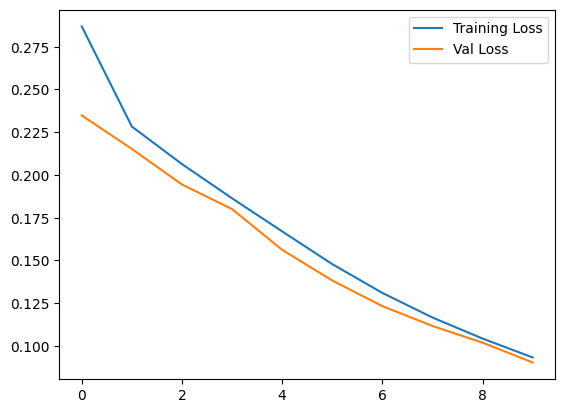

In [53]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()

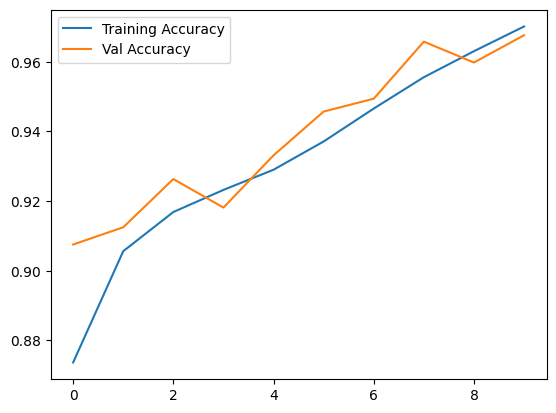

In [54]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.84      0.98      0.90      2498
        True       1.00      0.97      0.98     16085

    accuracy                           0.97     18583
   macro avg       0.92      0.97      0.94     18583
weighted avg       0.97      0.97      0.97     18583



0.9734563280092523


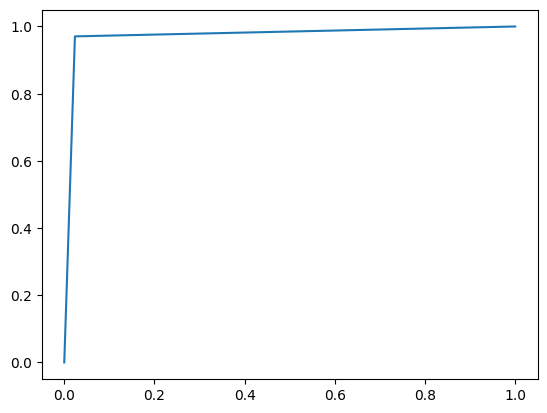

In [62]:
fpr, tpr, t = roc_curve(y_test, y_pred)
auc_ = auc(fpr, tpr)
plt.plot(fpr, tpr)
print(auc_)